En general, se considera que existen 5 posibles arquitecturas básicas de redes neuronales recurrentes:

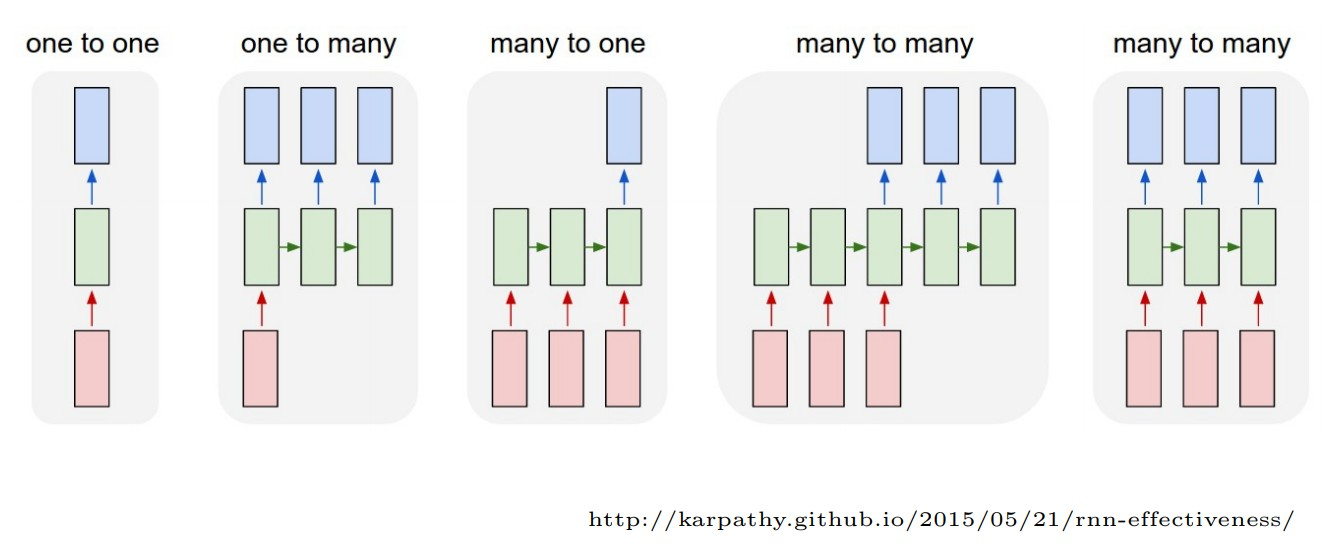

# Setup

In [66]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# One to many
## Concepto
Los problemas *one-to-many* son problemas secuenciales en los que:
- La entrada corresponde a un único valor o *time-step*.
- La salida es un vector que contiene múltiples valores o *time-steps*.

Es decir, por cada valor de entrada, se genera más de un valor de salida.


Un ejemplo es la generación automática de subtítulos de imágenes. 

***Artículo interesante: https://wandb.ai/authors/image-captioning/reports/Generate-Meaningful-Captions-for-Images-with-Attention-Models--VmlldzoxNzg0ODA***

## Implementación

En primer lugar, generamos un dataset de ejemplo:

In [12]:
# Generamos la X
X = [x for x in range(1, 44, 3)]
print(X)
print(len(X))

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]
15


In [13]:
# Generamos la Y (variable target)
Y = list()

for i in X:
    output_vector = list()
    output_vector.append(i+1)
    output_vector.append(i+2)
    Y.append(output_vector)
    
print(Y)
print(len(Y))

[[2, 3], [5, 6], [8, 9], [11, 12], [14, 15], [17, 18], [20, 21], [23, 24], [26, 27], [29, 30], [32, 33], [35, 36], [38, 39], [41, 42], [44, 45]]
15


Convertimos las listas anteriores en vectores de Numpy con un formato adecuado:

In [16]:
X = np.array(X).reshape(len(X), 1, 1)
print(X)

[[[ 1]]

 [[ 4]]

 [[ 7]]

 [[10]]

 [[13]]

 [[16]]

 [[19]]

 [[22]]

 [[25]]

 [[28]]

 [[31]]

 [[34]]

 [[37]]

 [[40]]

 [[43]]]


In [17]:
Y = np.array(Y)
Y

array([[ 2,  3],
       [ 5,  6],
       [ 8,  9],
       [11, 12],
       [14, 15],
       [17, 18],
       [20, 21],
       [23, 24],
       [26, 27],
       [29, 30],
       [32, 33],
       [35, 36],
       [38, 39],
       [41, 42],
       [44, 45]])

La entrada a la red será un único valor, mientras que la salida será una secuencia de los dos valores siguientes. 

In [18]:
X.shape

(15, 1, 1)

Vamos a entrenar un modelo básico con arquitectura de tipo *one-to-many*. Además, aplicaremos *early stopping*, de tal forma que cuando la métrica monitoreada deje de mejorar, el entrenamiento se detenga.

La cantidad exacta de paciencia en el early stopping variará entre modelos y problemas. Revisar los gráficos de la métrica de rendimiento puede ser muy útil para tener una idea de lo ruidoso que es el proceso de optimización para un modelo en particular.

De forma predeterminada, cualquier cambio en la medida de rendimiento, sin importar cómo de pequeño sea, se considerará una mejora. Sin embargo, es posible considerar una mejora que sea un incremento específico, como 1 unidad para el error cuadrático medio o 1% para la precisión. Esto se puede especificar mediante el argumento "min_delta".

In [34]:
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(2))

model.compile(optimizer="adam", 
              loss="mse")

# Creamos un callback de early stopping
early_stopping = EarlyStopping(monitor="val_loss", 
                               patience=5, 
                               verbose=1,
                               min_delta = 1)

model.fit(X, Y, epochs=1000, 
          validation_split=0.2, 
          batch_size=3,
          callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 1s 93ms/step - loss: 471.5143 - val_loss: 1736.9951
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 466.0550 - val_loss: 1713.5352
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 459.6812 - val_loss: 1691.3483
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 453.2799 - val_loss: 1669.1206
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 447.9784 - val_loss: 1644.6260
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 440.2025 - val_loss: 1619.8173
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 433.2039 - val_loss: 1592.2559
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 426.3744 - val_loss: 1561.0397
Epoch 9/1000
4/4 [==============================] - 0s 16ms/step - loss: 416.4931 - val_loss: 1528.8243
Epoch 10/1000
4/4 [==============================] - 0s 16ms/ste

In [35]:
# Generamos un input de prueba
test_input = np.array([10])

# Lo formateamos correctamente
test_input = test_input.reshape((1, 1, 1))

# Comprobamos 
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[7.9616065 8.590431 ]]


El rendimiento en el modelo no es el que cabría esperar, y esto puede deberse a varios motivos, como por ejemplo:

- Haber esperado demasiado en el early stopping. 
- Haber sido demasiado estrictos con el criterio de parada *min_delta*.

# Many to one
## Concepto
En este tipo de problemas, se introduce una secuencia de varios valores y se espera un único valor de salida.

Un ejemplo es el análisis de sentimiento o la clasificación de texto.

## Implementación

In [54]:
# Generamos la X
X = np.array([x for x in range(1, 46)])
print(X)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


Vamos a formatear la X de tal forma que contenga 15 muestras de 3 valores cada una:

In [55]:
# Reformateamos la X
X = X.reshape(15,3,1)
print(X)

[[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]]


In [57]:
# Creamos la Y, de tal forma que cada uno de sus valores sea la suma
# de los 3 valores de X que le corresponden
Y = list()
for x in X:
    Y.append(x.sum())

Y = np.array(Y)
print(Y)

[  6  15  24  33  42  51  60  69  78  87  96 105 114 123 132]


In [58]:
model = Sequential()
model.add(LSTM(50, 
               activation='relu', 
               input_shape=(3, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', 
              loss='mse')

history = model.fit(X, Y, 
                    epochs=1000, 
                    validation_split=0.2, 
                    verbose=1)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 4106.7871 - val_loss: 15548.5820
Epoch 2/1000
1/1 [==============================] - 0s 48ms/step - loss: 4073.0369 - val_loss: 15422.8330
Epoch 3/1000
1/1 [==============================] - 0s 32ms/step - loss: 4038.9773 - val_loss: 15295.8545
Epoch 4/1000
1/1 [==============================] - 0s 32ms/step - loss: 4004.5349 - val_loss: 15167.2891
Epoch 5/1000
1/1 [==============================] - 0s 48ms/step - loss: 3969.6152 - val_loss: 15036.6748
Epoch 6/1000
1/1 [==============================] - 0s 40ms/step - loss: 3934.1016 - val_loss: 14903.4326
Epoch 7/1000
1/1 [==============================] - 0s 32ms/step - loss: 3897.8601 - val_loss: 14766.8545
Epoch 8/1000
1/1 [==============================] - 0s 32ms/step - loss: 3860.7087 - val_loss: 14626.1484
Epoch 9/1000
1/1 [==============================] - 0s 32ms/step - loss: 3822.4453 - val_loss: 14480.4131
Epoch 10/1000
1/1 [=============================

Epoch 160/1000
1/1 [==============================] - 0s 24ms/step - loss: 3.4050 - val_loss: 4.7979
Epoch 161/1000
1/1 [==============================] - 0s 24ms/step - loss: 3.3375 - val_loss: 4.5679
Epoch 162/1000
1/1 [==============================] - 0s 32ms/step - loss: 3.2711 - val_loss: 4.3823
Epoch 163/1000
1/1 [==============================] - 0s 24ms/step - loss: 3.2058 - val_loss: 4.2395
Epoch 164/1000
1/1 [==============================] - 0s 32ms/step - loss: 3.1414 - val_loss: 4.1363
Epoch 165/1000
1/1 [==============================] - 0s 24ms/step - loss: 3.0778 - val_loss: 4.0675
Epoch 166/1000
1/1 [==============================] - 0s 32ms/step - loss: 3.0152 - val_loss: 4.0274
Epoch 167/1000
1/1 [==============================] - 0s 40ms/step - loss: 2.9535 - val_loss: 4.0100
Epoch 168/1000
1/1 [==============================] - 0s 40ms/step - loss: 2.8929 - val_loss: 4.0089
Epoch 169/1000
1/1 [==============================] - 0s 32ms/step - loss: 2.8334 - val_los

1/1 [==============================] - 0s 32ms/step - loss: 0.7241 - val_loss: 1.8104
Epoch 242/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.7119 - val_loss: 1.7861
Epoch 243/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.7000 - val_loss: 1.7624
Epoch 244/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.6884 - val_loss: 1.7392
Epoch 245/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.6770 - val_loss: 1.7165
Epoch 246/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.6658 - val_loss: 1.6941
Epoch 247/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.6549 - val_loss: 1.6722
Epoch 248/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.6442 - val_loss: 1.6507
Epoch 249/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.6338 - val_loss: 1.6296
Epoch 250/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.6236 - val_loss: 1.6089
Epoch

1/1 [==============================] - 0s 40ms/step - loss: 0.2591 - val_loss: 0.8776
Epoch 323/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2569 - val_loss: 0.8739
Epoch 324/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2548 - val_loss: 0.8703
Epoch 325/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2528 - val_loss: 0.8669
Epoch 326/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.2508 - val_loss: 0.8635
Epoch 327/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2488 - val_loss: 0.8602
Epoch 328/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2469 - val_loss: 0.8571
Epoch 329/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.2450 - val_loss: 0.8540
Epoch 330/1000
1/1 [==============================] - ETA: 0s - loss: 0.243 - 0s 32ms/step - loss: 0.2431 - val_loss: 0.8510
Epoch 331/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.2413 

1/1 [==============================] - 0s 32ms/step - loss: 0.1610 - val_loss: 0.7878
Epoch 404/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.1603 - val_loss: 0.7882
Epoch 405/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.1596 - val_loss: 0.7886
Epoch 406/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1589 - val_loss: 0.7890
Epoch 407/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1582 - val_loss: 0.7894
Epoch 408/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.1575 - val_loss: 0.7899
Epoch 409/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.1569 - val_loss: 0.7903
Epoch 410/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1562 - val_loss: 0.7908
Epoch 411/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.1555 - val_loss: 0.7913
Epoch 412/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.1549 - val_loss: 0.7918
Epoch

1/1 [==============================] - 0s 13ms/step - loss: 0.0881 - val_loss: 0.8961
Epoch 566/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0878 - val_loss: 0.8964
Epoch 567/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0875 - val_loss: 0.8967
Epoch 568/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0872 - val_loss: 0.8970
Epoch 569/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0868 - val_loss: 0.8973
Epoch 570/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0865 - val_loss: 0.8975
Epoch 571/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0862 - val_loss: 0.8978
Epoch 572/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0859 - val_loss: 0.8981
Epoch 573/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0856 - val_loss: 0.8983
Epoch 574/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0853 - val_loss: 0.8985
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 0.0496 - val_loss: 0.8488
Epoch 728/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0495 - val_loss: 0.8479
Epoch 729/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0493 - val_loss: 0.8471
Epoch 730/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0491 - val_loss: 0.8462
Epoch 731/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0489 - val_loss: 0.8454
Epoch 732/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0488 - val_loss: 0.8445
Epoch 733/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0486 - val_loss: 0.8437
Epoch 734/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0484 - val_loss: 0.8428
Epoch 735/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0482 - val_loss: 0.8419
Epoch 736/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0481 - val_loss: 0.8411
Epoch

1/1 [==============================] - 0s 40ms/step - loss: 0.0277 - val_loss: 0.6760
Epoch 890/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0276 - val_loss: 0.6749
Epoch 891/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0275 - val_loss: 0.6737
Epoch 892/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0274 - val_loss: 0.6726
Epoch 893/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0273 - val_loss: 0.6714
Epoch 894/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0272 - val_loss: 0.6702
Epoch 895/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0271 - val_loss: 0.6690
Epoch 896/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.0270 - val_loss: 0.6679
Epoch 897/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.0269 - val_loss: 0.6667
Epoch 898/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0268 - val_loss: 0.6655
Epoch

In [59]:
# El output para este input debería ser 153
test_input = np.array([50,51,52])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[151.07913]]


# Many to many
## Concepto
En este tipo de problemas, tanto la entrada como la salida de la red son secuencias de varios valores.

Un ejemplo de aplicación es la traducción automática de idiomas, ya que el input son secuencias en un idioma, mientras que el output siguen siendo secuencias pero traducidas a otro idioma. 

Para este tipo de casos, es común utilizar redes *Encoder-Decoder*, las cuales tienen dos capas LSTM, como veremos a continuación.

## Implementación

In [60]:
X = [x for x in range(5, 301, 5)]
Y = [y for y in range(20, 316, 5)]

X = np.array(X).reshape(20, 3, 1)
Y = np.array(Y).reshape(20, 3, 1)

In [61]:
print(X)

[[[  5]
  [ 10]
  [ 15]]

 [[ 20]
  [ 25]
  [ 30]]

 [[ 35]
  [ 40]
  [ 45]]

 [[ 50]
  [ 55]
  [ 60]]

 [[ 65]
  [ 70]
  [ 75]]

 [[ 80]
  [ 85]
  [ 90]]

 [[ 95]
  [100]
  [105]]

 [[110]
  [115]
  [120]]

 [[125]
  [130]
  [135]]

 [[140]
  [145]
  [150]]

 [[155]
  [160]
  [165]]

 [[170]
  [175]
  [180]]

 [[185]
  [190]
  [195]]

 [[200]
  [205]
  [210]]

 [[215]
  [220]
  [225]]

 [[230]
  [235]
  [240]]

 [[245]
  [250]
  [255]]

 [[260]
  [265]
  [270]]

 [[275]
  [280]
  [285]]

 [[290]
  [295]
  [300]]]


In [62]:
print(Y)

[[[ 20]
  [ 25]
  [ 30]]

 [[ 35]
  [ 40]
  [ 45]]

 [[ 50]
  [ 55]
  [ 60]]

 [[ 65]
  [ 70]
  [ 75]]

 [[ 80]
  [ 85]
  [ 90]]

 [[ 95]
  [100]
  [105]]

 [[110]
  [115]
  [120]]

 [[125]
  [130]
  [135]]

 [[140]
  [145]
  [150]]

 [[155]
  [160]
  [165]]

 [[170]
  [175]
  [180]]

 [[185]
  [190]
  [195]]

 [[200]
  [205]
  [210]]

 [[215]
  [220]
  [225]]

 [[230]
  [235]
  [240]]

 [[245]
  [250]
  [255]]

 [[260]
  [265]
  [270]]

 [[275]
  [280]
  [285]]

 [[290]
  [295]
  [300]]

 [[305]
  [310]
  [315]]]


En el modelo secuencial, se va a hacer uso del wrapper de keras *TimeDistributed*, que permite aplicar una capa a cada segmento temporal de una entrada. 

Para entender cómo funciona este wrapper, consideremos un lote de 32 muestras de un vídeo, donde cada muestra es una imagen RGB de 128x128 con formato de datos channels_last, en 10 pasos de tiempo. La forma de entrada del lote es (32, 10, 128, 128, 3).

Utilizando *TimeDistributed* es posible aplicar la misma capa Conv2D a cada uno de los 10 pasos de tiempo, de forma independiente.

In [67]:
model = Sequential()

# Capa encoder
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))

# Se repite el vector 3 veces
model.add(RepeatVector(3))

# Capa decoder
model.add(LSTM(100, activation='relu', return_sequences=True))

# 
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')

print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 100)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 3, 100)            80400     
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
history = model.fit(X, Y, 
                    epochs=1000, 
                    validation_split=0.2, 
                    verbose=1, 
                    batch_size=3)

Epoch 1/1000
6/6 [==============================] - 3s 74ms/step - loss: 22829.3750 - val_loss: 69486.9453
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 18339.2969 - val_loss: 53975.1016
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 12442.2793 - val_loss: 23617.5547
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 6575.4458 - val_loss: 22339.8223
Epoch 5/1000
6/6 [==============================] - 0s 8ms/step - loss: 4971.2139 - val_loss: 14240.8301
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 3887.2085 - val_loss: 11900.9033
Epoch 7/1000
6/6 [==============================] - 0s 6ms/step - loss: 2891.3398 - val_loss: 7752.1128
Epoch 8/1000
6/6 [==============================] - 0s 8ms/step - loss: 1761.6116 - val_loss: 4138.9194
Epoch 9/1000
6/6 [==============================] - 0s 8ms/step - loss: 904.5316 - val_loss: 2046.8574
Epoch 10/1000
6/6 [==============================] -

6/6 [==============================] - 0s 10ms/step - loss: 0.0764 - val_loss: 0.2913
Epoch 83/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0956 - val_loss: 0.2916
Epoch 84/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0835 - val_loss: 0.6456
Epoch 85/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0999 - val_loss: 0.6667
Epoch 86/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0771 - val_loss: 0.4750
Epoch 87/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0581 - val_loss: 0.4704
Epoch 88/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0559 - val_loss: 0.6231
Epoch 89/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0644 - val_loss: 0.5908
Epoch 90/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0526 - val_loss: 0.4975
Epoch 91/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0521 - val_loss: 0.3518
Epoch 92/1000


6/6 [==============================] - 0s 6ms/step - loss: 0.0192 - val_loss: 0.7119
Epoch 245/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.8612
Epoch 246/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.9015
Epoch 247/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0506 - val_loss: 0.5135
Epoch 248/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0185 - val_loss: 0.3694
Epoch 249/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0419 - val_loss: 0.2765
Epoch 250/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0480 - val_loss: 0.8429
Epoch 251/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.5925
Epoch 252/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.1683
Epoch 253/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0221 - val_loss: 0.5056
Epoch 254/1000


Epoch 326/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.1534 - val_loss: 4.6940
Epoch 327/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.3456 - val_loss: 0.2780
Epoch 328/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.2124 - val_loss: 0.1039
Epoch 329/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.1112 - val_loss: 0.2972
Epoch 330/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0521 - val_loss: 1.2537
Epoch 331/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0668 - val_loss: 1.6586
Epoch 332/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1095 - val_loss: 0.6105
Epoch 333/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0800 - val_loss: 0.0881
Epoch 334/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0271 - val_loss: 0.1383
Epoch 335/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0301 - val_loss: 0.226

Epoch 408/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0325 - val_loss: 0.9043
Epoch 409/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 1.1696
Epoch 410/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.1210 - val_loss: 3.1143
Epoch 411/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.2407 - val_loss: 2.3940
Epoch 412/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3367 - val_loss: 10.3253
Epoch 413/1000
6/6 [==============================] - 0s 5ms/step - loss: 1.1155 - val_loss: 6.9563
Epoch 414/1000
6/6 [==============================] - 0s 5ms/step - loss: 1.0076 - val_loss: 0.2850
Epoch 415/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.8222 - val_loss: 0.2242
Epoch 416/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.8524 - val_loss: 0.8580
Epoch 417/1000
6/6 [==============================] - 0s 5ms/step - loss: 1.2018 - val_loss: 0.5570

6/6 [==============================] - 0s 5ms/step - loss: 0.1074 - val_loss: 1.6153
Epoch 571/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0809 - val_loss: 1.6954
Epoch 572/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.1942 - val_loss: 5.4922
Epoch 573/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.0033 - val_loss: 10.7430
Epoch 574/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.7333 - val_loss: 0.2596
Epoch 575/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4025 - val_loss: 1.1055
Epoch 576/1000
6/6 [==============================] - 0s 5ms/step - loss: 2.0465 - val_loss: 5.8734
Epoch 577/1000
6/6 [==============================] - 0s 5ms/step - loss: 3.0320 - val_loss: 0.8600
Epoch 578/1000
6/6 [==============================] - 0s 5ms/step - loss: 3.9727 - val_loss: 11.7835
Epoch 579/1000
6/6 [==============================] - 0s 6ms/step - loss: 4.0592 - val_loss: 6.0375
Epoch 580/100

Epoch 733/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0473 - val_loss: 0.6249
Epoch 734/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0249 - val_loss: 0.9182
Epoch 735/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0454 - val_loss: 0.1132
Epoch 736/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2313 - val_loss: 0.1119
Epoch 737/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2019 - val_loss: 0.1009
Epoch 738/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2938 - val_loss: 0.3441
Epoch 739/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.3066 - val_loss: 0.4103
Epoch 740/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1619 - val_loss: 3.2318
Epoch 741/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.1156 - val_loss: 2.3653
Epoch 742/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.1002 - val_loss: 

6/6 [==============================] - 0s 6ms/step - loss: 0.2741 - val_loss: 0.0828
Epoch 897/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0872 - val_loss: 0.1231
Epoch 898/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0562 - val_loss: 0.1092
Epoch 899/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0339 - val_loss: 0.2338
Epoch 900/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.6012
Epoch 901/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.6671
Epoch 902/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.4672
Epoch 903/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.0262 - val_loss: 0.7746
Epoch 904/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0531 - val_loss: 1.1742
Epoch 905/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0351 - val_loss: 1.0520
Epoch 906/100

Epoch 977/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3122 - val_loss: 5.6316
Epoch 978/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6668 - val_loss: 7.4025
Epoch 979/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.8611 - val_loss: 1.0235
Epoch 980/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5223 - val_loss: 2.0390
Epoch 981/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.6157 - val_loss: 2.8359
Epoch 982/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.4798 - val_loss: 4.5753
Epoch 983/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.7344 - val_loss: 1.4649
Epoch 984/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.5181 - val_loss: 1.0639
Epoch 985/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.5042 - val_loss: 1.0595
Epoch 986/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.7507 - val_loss: 1.

In [69]:
test_input = np.array([300, 305, 310])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)

print(test_output)

[[[314.7592 ]
  [321.86368]
  [329.2748 ]]]
